## Numerical solution of the radiative transfer equation 

#### And what do do with it 

This is our first proper hands-on. Here we will get familiar with spectum calculation (modeling).

To calculate the spectrum of the object in question we need the following: 

- To choose a line of sight, the straight line we are solving RTE along 
- To specify a boundary condition or : incoming intensity on the "other" side of the object. 
- Opacity and emissivity variation over the line of sight so that we can solve rte:

$$\frac{dI_\lambda}{dl} = j_\lambda - \chi_\lambda I_\lambda $$

#### In our case we will: 

- Use atmospheric normal as a line of sight, that is, we will start at the bottom of the solar atmosphere and go straight "up", solving RTE along that line of sight
- Use the Blackbody radiation at the appropriate temperature (see below) as a boundary condition at the "bottom" of the atmosphere
- Instead of using directly opacity and emissivity (but see independent work), we will specify a somewhat ad hoc optical depth and source function and solve:

$$\frac{dI_\lambda}{d\tau_\lambda} = I_\lambda - S_\lambda $$

All these will come from a model atmosphere we will load and use here.

#### A little sketch to put everything in context (yes I love drawing :)) 

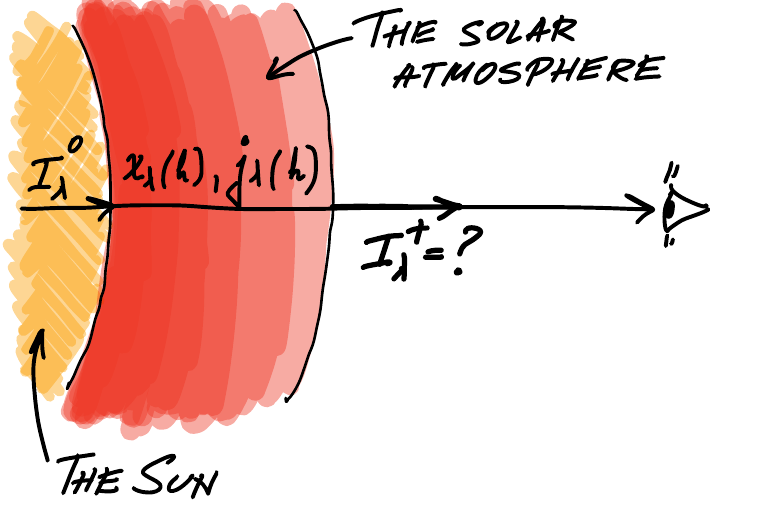

### Step zero: import python modules you are going to use. 

In [4]:
import numpy as np # basic mathematical and numerical functionallity 
import matplotlib.pyplot as plt # some plotting functionallity, for various things we will do

import matplotlib
matplotlib.rcParams.update({
    "text.usetex": False,
    "font.size" : 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

# This last line will give us a little bit nicer plot labeling

### Step one: load the "model" atmosphere and visualize it! 

We did not talk about this earlier but model atmosphere is basically just an array of values of physical quantities of interest on a depth grid, the one we are loading has total od 12 tabulated values, and the ones we are currently interested in are:

- 0 - Optical depth in the continuum (in log scale) 
- 1 - Height in cm 
- 2 - Temperature 
- 3 - Gas presure 
- 4 - Electron pressure

Note - all the units are in the so called CGS system

For the moment we can live without the others, let's load famous FALC model from Fontenla et. al. (1993) and visualize it:

In [5]:
atmos = np.loadtxt("falc.dat",unpack=True,skiprows=1)

# Doing atmos.shape will show us the dimensions of the array. 
# It's usually the easiest way to see if everything is ok with the data 

atmos.shape

(12, 57)

Text(0, 0.5, '$T [K]$')

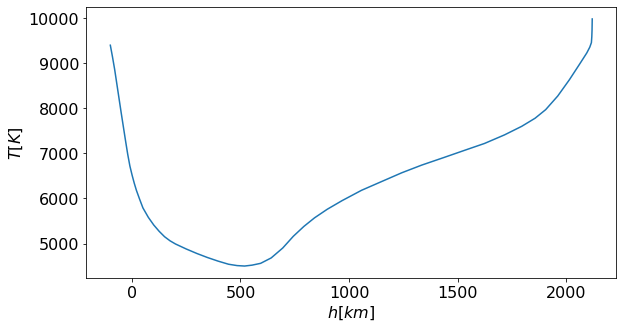

In [8]:
# The next easiest way to see if everything is ok with the data is to just plot it 
# Let's plot variation of temperature with height

h = np.copy(atmos[1]) / 1E5 # I am using np.copy not to disturb the original array
T = np.copy(atmos[2])

plt.figure(figsize=[9.5,5])
plt.plot(h,T)
plt.xlabel("$h [km]$")
plt.ylabel("$T [K]$")

#### To-do on your own : Plot various other quantities (you can even do ones I did not specify what they are). Can you guess what other quantities are?

Especially interesting is variation between log optical depth and height, you will see it is very linear-ish. Can you guess why?

Text(0, 0.5, '$\\log \\tau$')

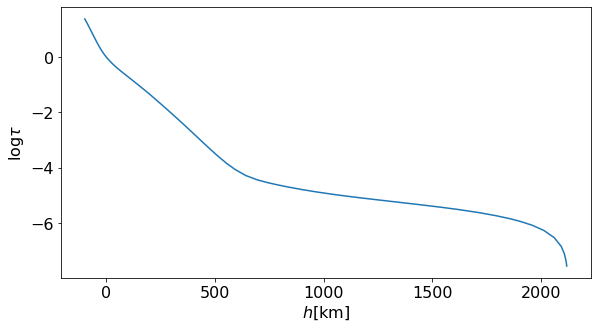

In [9]:
logtau = np.copy(atmos[0])
plt.figure(figsize=[9.5,5])
plt.plot(h,logtau)
plt.xlabel("$h [{\mathrm {km}}]$")
plt.ylabel("$\log \\tau$")

### Step two: specify source function and optical depth (at multiple wavelength in a spectral line).

We will now make an ad hoc spectral line. We will do something similar to what we did last time. Namely we will describe spectral line using couple of parameters: 

- Strength of the line with respect to continuum. Namely we will specify a number that scales the line optical depth with respect to continuum.
- Line profile. We will assume it to be constant and parametrized by line widht and line damping. 
- This will allow us to make a very simple model of atomic lines and have a grid of optical depths that corresponds to a grid of wavelengths.
- We will say that the source function is proportional to the temperature, and constant with waveleneght, can you tell me why?

### $$S_\lambda = \frac{2hc^2}{\lambda^5} \frac{1}{e^{hc/\lambda k T} - 1}$$

In [10]:
# So for start we can say, not worrying about the units: 
S = np.copy(T)

Calculating the shape of the spectral line will be less easy. I can tell you now (and you can look in Mihalas or Rutten books), that the shape of the spectral line can be represented as: 

### $$\phi_\lambda = H(\Delta_\lambda,a)$$

Where $H$ is the Voigt function, $\Delta_\lambda$ is the line doppler width, usually calculated as: 

$$\Delta_\lambda = \frac{\lambda_0}{c} \sqrt{\frac{2kT}{m} + v_t^2} $$

Where $v_t$ is the so called turbulent velocity. This is a very weird concept and when we talk about the photosphere and chromosphere we will have to mention it. For the moment, let's just assume it's there.

$a$ is the ratio of line damping to the Doppler broadening, in frequency units. We could write it like this: 

$$a = \frac{\Gamma_{\rm damp}}{\nu_0 \Delta_\lambda / \lambda_0 } $$

Let's try and estimate some of these for a given line. We can use a famous photospheric line for this! Let's use an iron line around 525 nm, which is well known for photosperic diagnostics!

In [11]:
llambda_0 = 525E-9 # I can use SI now but be careful later because original atmosphere model is in CGS
llambda = np.linspace(524.5,525.5,501)*1E-9 # this gives us a uniform wavelength grid

k = 1.38E-23 # Boltzmann constant 
c = 3E8 # speed of light

nu_0 = c/llambda_0 # frequency

Gamma_damping = 1E7 # Can we discuss this? Why did I choose this value specifically?

v_t = 1E3 # Also this! Why this value?

m = 56. * 1.66E-27 # Mass of an iron atom in kG

An important thing to notice here is that the line broadening is depth dependent! So I will have a separate line profile for each depth. A little bit of work, but ok! Another thing that we need is we actually need a voigt function. Sadly it is not as common as we would like. Let's first test that one out:

In [12]:
# Testing Voigt profile:

# Actually it is a great pain in the neck to find an out-of-the box Voigt function. 
# (at least for me)
# So we are going to make our own according to:
# https://scipython.com/book/chapter-8-scipy/examples/the-voigt-profile/

from scipy.special import wofz
def V(x, alpha, gamma):
    
    #Return the Voigt line shape at x with Lorentzian component HWHM gamma
    #and Gaussian component HWHM alpha.

    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / sigma\
                                                           /np.sqrt(2*np.pi)

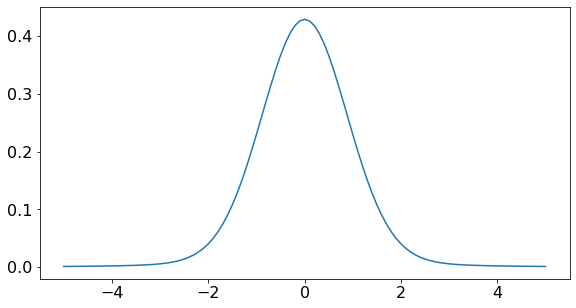

In [13]:
# Let's test it in the so called normalized units

x = np.linspace(-5,5,101)
alpha = 1
gamma = 0.1
plt.figure(figsize=[9.5,5])
plt.plot(x,V(x,alpha,gamma))

Looks good! You can experiment with various values of Gamma (which is our $a$), and see what comes up! 

### Step 2.1: Calculate depth-dependent line profile and thus optical depth

We now know everything we need for a profile, but keep in mind we are also using the so called line "strength" to model the total amount of absorption done by the spectral line. 

#### Discuss: What does this parameter replace?

Text(0, 0.5, 'Line profile')

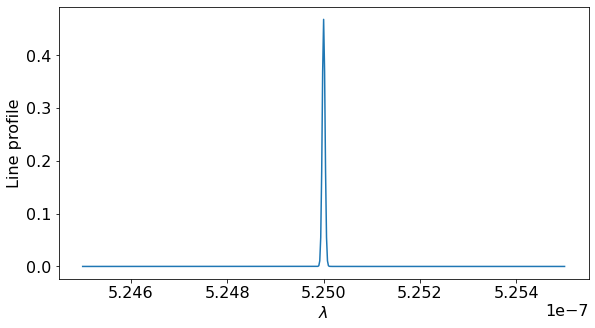

In [14]:
# Let's immediately define line-to-continuum opacity ratio, assume it's depth independent
r = 50.0

# Then let's define arrays where we will put our depth and wavelength dependent line profile and optical depth:
ND = len(logtau)
NL = len(llambda)
phi_lambda = np.zeros([ND,NL])
tau_lambda = np.zeros([ND,NL])

# Let's test the procedure for a given depth, say the deepmost point of the atmosphere:
d = ND-1

# Calculate line Doppler width
delta_lambda_d = llambda_0/c * np.sqrt(2*k*T[d]/m + v_t**2.0)

# Calculate line damping
a = Gamma_damping * llambda_0 / delta_lambda_d / nu_0
    
x = (llambda-llambda_0) / delta_lambda_d  # Do you see why? These are so called normalized wavelength

phi_lambda[d] = V(x,1,a)
    
# And plot phi to know what are we talking about:

plt.figure(figsize=[9.5,5])
plt.plot(llambda,phi_lambda[d])
plt.xlabel("$\\lambda$")
plt.ylabel("Line profile")


What does this tell us? Well, that we have chosen too broad wavelength grid. Maybe we can change and try again! It's fine, we did not have feeling for the values of the parameters. We will develop this with time :-)

Text(0, 0.5, 'Line profile')

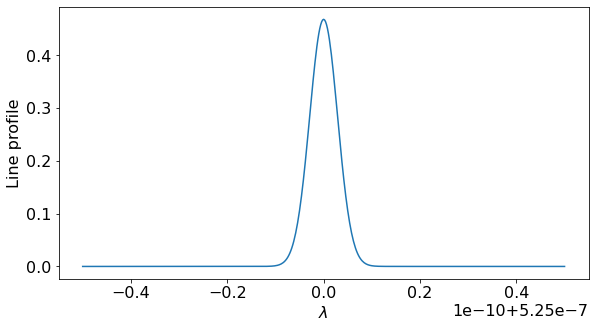

In [15]:
llambda = np.linspace(524.95,525.05,501)*1E-9 # this gives us a uniform wavelength grid
# Let's test the procedure for a given depth, say the deepmost point of the atmosphere:
d = ND-1

# Calculate line Doppler width
delta_lambda_d = llambda_0/c * np.sqrt(2*k*T[d]/m + v_t**2.0)

# Calculate line damping
a = Gamma_damping * llambda_0 / delta_lambda_d / nu_0
    
x = (llambda-llambda_0) / delta_lambda_d  # Do you see why? These are so called normalized wavelength

phi_lambda[d] = V(x,1,a)
    
# And plot phi to know what are we talking about:

plt.figure(figsize=[9.5,5])
plt.plot(llambda,phi_lambda[d])
plt.xlabel("$\\lambda$")
plt.ylabel("Line profile")

#### Much better! Now let's clear up the code and do this for every depth:

In [16]:
for d in range(0,ND):

    # Calculate line Doppler width
    delta_lambda_d = llambda_0/c * np.sqrt(2*k*T[d]/m + v_t**2.0)
    # Calculate line damping
    a = Gamma_damping * llambda_0 / delta_lambda_d / nu_0
    # Scale
    x = (llambda-llambda_0) / delta_lambda_d
    # Profile
    phi_lambda[d] = V(x,1,a)
    # Optical depth:
    tau_lambda[d,:] = 10.**(logtau[d]) * (1+ r *phi_lambda[d])

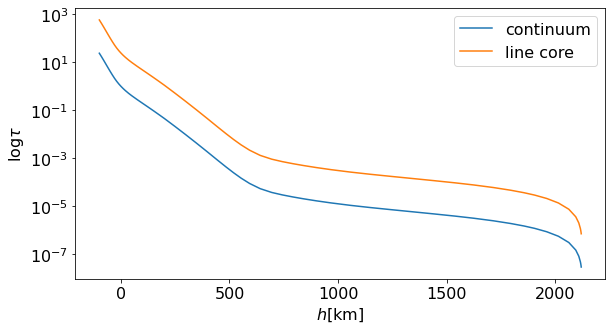

In [18]:
# We can plot the optical depth at two wavelengts to se if this makes sense
plt.figure(figsize=[9.5,5])
plt.semilogy(h,tau_lambda[:,0],label='continuum') # continuum
plt.semilogy(h,tau_lambda[:,NL//2],label='line core')
plt.xlabel("$h [{\mathrm {km}}]$")
plt.ylabel("$\log \\tau$")
plt.legend()

#### Kinda does! Great! Now, let's go and try to solve radiative transfer equation.

### Step Three : Solving RTE

Now we have $S_\lambda(\tau_\lambda)$ dependency for each wavelenght, so we can solve radiative transfer equation. 

Obviously we need to solve RTE numerically as we have no analytical form of our source function. What do we do? 

Well, we obviously have to devide our atmosphere in series of little "slabs".

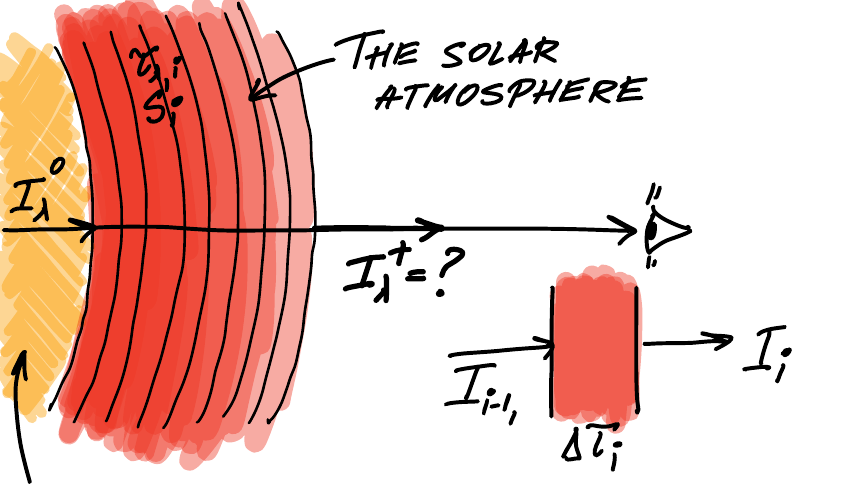

If we assume each slab is homogeneous, for each wavelength and each slab we have: 

### $$ I_i = I_{i+1} e^{-\Delta\tau_i} + S(1-e^{-\Delta\tau_i}) $$

where 

$$S = \frac{S_i + S_{i+1}}{2} $$

Don't be too confused with the idea that we are going from the higher $i$ to the lower $i$, that is just how optical depths work! 

### Let's go! 

In [19]:
# Solving RTE numerically:

# Set up boundary condition, at the bottom I = S (LTE)
I_inc = np.zeros(NL)
I_inc[:] = S[-1]

Intensity = np.zeros([ND,NL])
# We use boundary condition:
Intensity[-1,:] = I_inc

# And then we apply the solution we outlined above: 
for d in range(ND-2,-1,-1):
    
    delta_tau = tau_lambda[d+1] - tau_lambda[d]
    S_mean = (S[d+1] + S[d]) * 0.5
    Intensity[d] = Intensity[d+1] * np.exp(-delta_tau) + S_mean * (1.- np.exp(-delta_tau))


How to test this? Well, we plot the spectrum. What is the spectrum?

### Dependency of emergent intensity on wavelength:

Text(0, 0.5, 'Emergent Intensity')

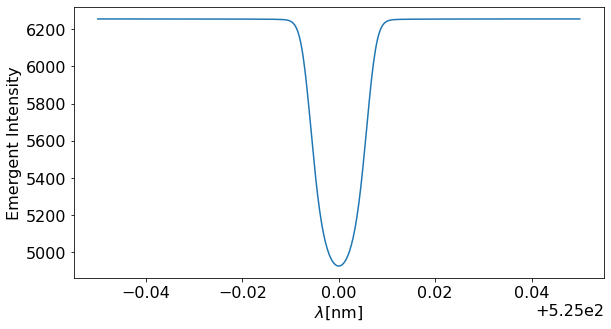

In [20]:
plt.figure(figsize=[9.5,5])
plt.plot(llambda*1E9,Intensity[0])
plt.xlabel("$\\lambda [\mathrm {nm}]$")
plt.ylabel("Emergent Intensity")

### Wow! A spectral line! There are many questions now:

- Which units are these? 
- Why does it not reach lower? 
- What would happen if we changed some parameters? $r$ for example?
- Can we test how introducing the velocity in the solar atmosphere would influence this. 
- What about analyzing how the shape of the line changes with depth?

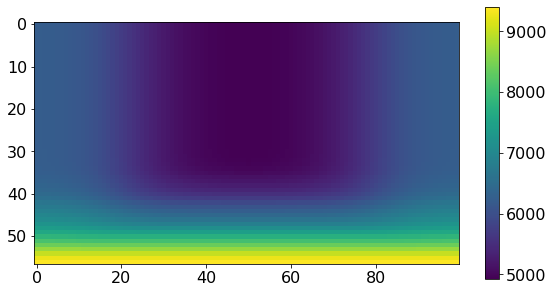

In [21]:
# Let's solve the last one as it is particularly interesting:
plt.figure(figsize=[9.5,5])
plt.imshow(Intensity[:,200:300])
plt.colorbar()

###  Quality of life thing : put the whole synthesis part in one chunk

This is important both to allow us to model more quickly but also to understand the "workflow" so to speak. schematically the synthesis part can be illustrated by: 

### $$I_\lambda ^+ = \mathcal{S}[\mathrm{atmos}, \mathrm {atoms}] $$

Where "atmos" contains of all the macroscopic data, which is the atmospheric model, in our language it is simply 2D array atmos from the above. 

"Atoms" contains all the atomic data which is in our langauge line-to-continuum strength (should depend on both), damping and mass (to calculate broadening).

This is very simplified, how would this work in the real life?

In [26]:
# Let's go 

def synthesis(atmos,atoms,llambda):
    
    h = 6.626E-34
    c = 2.997E8
    k = 1.38E-23
    # First extrac data for atoms 
    m = atoms[0]
    Gamma_damping = atoms[1]
    r = atoms[2]
    llambda_0 = atoms[3]
    nu_0 = c/llambda_0
    
    # Then we take what we need from the atmos:
    T = np.copy(atmos[2])
    logtau = np.copy(atmos[0])
    v_z = np.copy(atmos[9])*1E-2
    # Source function
    #S = np.copy(T)
    S = 2*h*c**2.0 / llambda_0 **5.0 / (np.exp(h*c/llambda_0/k/T)-1.0)
    # Hard-set turbulent velocity
    v_t = 1E3
    
    # Then let's define arrays where we will put our depth and wavelength dependent line profile and optical depth:
    ND = len(logtau)
    NL = len(llambda)
    phi_lambda = np.zeros([ND,NL])
    tau_lambda = np.zeros([ND,NL])
    
    # Profile calculation:
    for d in range(0,ND):

        # Calculate line Doppler width
        delta_lambda_d = llambda_0/c * np.sqrt(2*k*T[d]/m + v_t**2.0)
        # Calculate line damping
        a = Gamma_damping * llambda_0 / delta_lambda_d / nu_0
        # Scale, and now I will also include los velocity there
        x = (llambda - llambda_0*(1+v_z[d]/c)) / delta_lambda_d
        # Profile
        phi_lambda[d] = V(x,1,a)
        # Optical depth:
        tau_lambda[d,:] = 10.**(logtau[d]) * (1+ r *phi_lambda[d])
        
    # Set up boundary condition, at the bottom I = S (LTE)
    I_inc = np.zeros(NL)
    I_inc[:] = S[-1]

    Intensity = np.zeros([ND,NL])
    # We use boundary condition:
    Intensity[-1,:] = I_inc

    # And then we apply the solution we outlined above: 
    for d in range(ND-2,-1,-1):
    
        delta_tau = tau_lambda[d+1] - tau_lambda[d]
        S_mean = (S[d+1] + S[d]) * 0.5
        Intensity[d] = Intensity[d+1] * np.exp(-delta_tau) + S_mean * (1.- np.exp(-delta_tau))

    return Intensity[0]

In [71]:
# Let's go 

def synthesis_cf(atmos,atoms,llambda):
    
    h = 6.626E-34
    c = 2.997E8
    k = 1.38E-23
    # First extrac data for atoms 
    m = atoms[0]
    Gamma_damping = atoms[1]
    r = atoms[2]
    llambda_0 = atoms[3]
    nu_0 = c/llambda_0
    
    # Then we take what we need from the atmos:
    T = np.copy(atmos[2])
    logtau = np.copy(atmos[0])
    v_z = np.copy(atmos[9])*1E-2
    # Source function
    #S = np.copy(T)
    S = 2*h*c**2.0 / llambda_0 **5.0 / (np.exp(h*c/llambda_0/k/T)-1.0)
    # Hard-set turbulent velocity
    v_t = 1E3
    
    # Then let's define arrays where we will put our depth and wavelength dependent line profile and optical depth:
    ND = len(logtau)
    NL = len(llambda)
    phi_lambda = np.zeros([ND,NL])
    tau_lambda = np.zeros([ND,NL])
    
    # Profile calculation:
    for d in range(0,ND):

        # Calculate line Doppler width
        delta_lambda_d = llambda_0/c * np.sqrt(2*k*T[d]/m + v_t**2.0)
        # Calculate line damping
        a = Gamma_damping * llambda_0 / delta_lambda_d / nu_0
        # Scale, and now I will also include los velocity there
        x = (llambda - llambda_0*(1+v_z[d]/c)) / delta_lambda_d
        # Profile
        phi_lambda[d] = V(x,1,a)
        # Optical depth:
        tau_lambda[d,:] = 10.**(logtau[d]) * (1+ r *phi_lambda[d])
        
    # Set up boundary condition, at the bottom I = S (LTE)
    I_inc = np.zeros(NL)
    I_inc[:] = S[-1]

    Intensity = np.zeros([ND,NL])
    # We use boundary condition:
    Intensity[-1,:] = I_inc
    cf = np.zeros([ND,NL])
    cf[-1,:] = S[-1]

    # And then we apply the solution we outlined above: 
    for d in range(ND-2,-1,-1):
    
        delta_tau = tau_lambda[d+1] - tau_lambda[d]
        S_mean = (S[d+1] + S[d]) * 0.5
        Intensity[d] = Intensity[d+1] * np.exp(-delta_tau) + S_mean * (1.- np.exp(-delta_tau))
        #cf[:d+2,:] *= np.exp(-delta_tau)
        cf[d+1,:] += 0.5*S[d+1] * (1.- np.exp(-delta_tau))
        cf[d,:] += 0.5*S[d] * (1.- np.exp(-delta_tau))
        
    cf[:,:] *= np.exp(-tau_lambda[:,:])
    return Intensity[0],cf

In [72]:
atom = np.array([m, 1E7, 50.0, 525.0E-9])

spectrum = synthesis(atmos,atom,llambda)

Text(0, 0.5, 'Emergent Intensity')

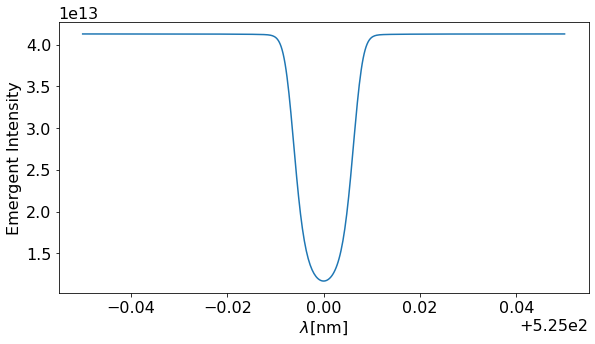

In [73]:
plt.figure(figsize=[9.5,5])
plt.plot(llambda*1E9,spectrum)
plt.xlabel("$\\lambda [\mathrm {nm}]$")
plt.ylabel("Emergent Intensity")

Text(0, 0.5, 'Emergent Intensity')

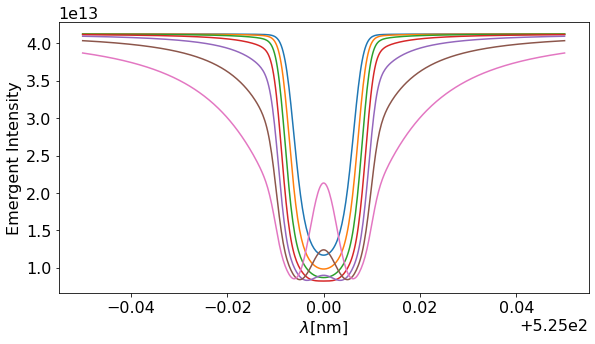

In [74]:
atom = np.array([m, 1E7, 50.0, 525.0E-9])

plt.figure(figsize=[9.5,5])
for i in range(0,7):
    spectrum = synthesis(atmos,atom,llambda)
    plt.plot(llambda*1E9,spectrum,label='r ='+str(atom[3]))
    atom[2] *= 3.0
plt.xlabel("$\\lambda [\mathrm {nm}]$")
plt.ylabel("Emergent Intensity")

### If there is time : Investigate the velocity effects on the emergent spectrum. 

We implemented above the effects of los velocity on the absorption profile. So we can change it and see how it influences the line.

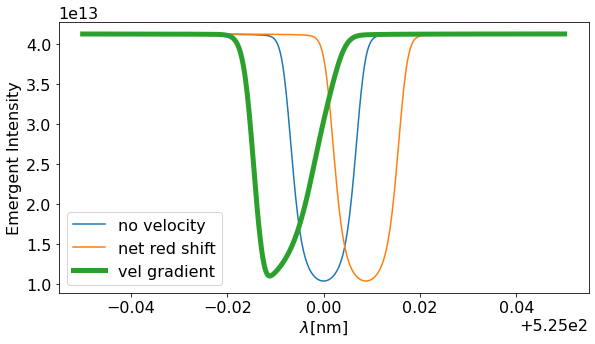

In [75]:
atom = np.array([m, 1E7, 100.0, 525.0E-9])
atmos[9,:] = 0E5 # in cm, to honor the original format
spectrum = synthesis(atmos,atom,llambda)

plt.figure(figsize=[9.5,5])
plt.plot(llambda*1E9,spectrum,label='no velocity')

atmos[9,:] = 5E5 # in cm, to honor the original format
spectrum = synthesis(atmos,atom,llambda)
plt.plot(llambda*1E9,spectrum,label='net red shift')

atmos[9,:] = -20E5 + np.arange(57) * 20.0E5/56. # in cm, to honor the original format
spectrum = synthesis(atmos,atom,llambda)
plt.plot(llambda*1E9,spectrum,linewidth=5,label='vel gradient')

plt.xlabel("$\\lambda [\mathrm {nm}]$")
plt.ylabel("Emergent Intensity")
plt.legend()

No handles with labels found to put in legend.


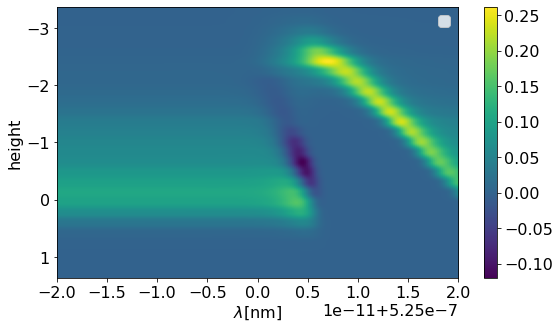

In [81]:
#atmos[9,:] = 0E5 # in cm, to honor the original format
atmos[9,:] = -10E5 + np.arange(57) * 20.0E5/56. # in cm, to honor the original format
plt.figure(figsize=[9,5])
spectrum,cf = synthesis_cf(atmos,atom,llambda)
plt.imshow(cf[30:,150:350]/spectrum[150:350],aspect='auto',extent=[llambda[150],llambda[350],logtau[-1],logtau[30]])
plt.colorbar()

plt.xlabel("$\\lambda [\mathrm {nm}]$")
plt.ylabel("height")
plt.legend()

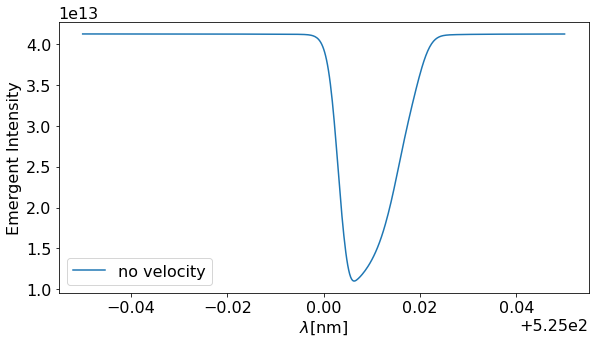

In [83]:
plt.figure(figsize=[9.5,5])
plt.plot(llambda*1E9,spectrum,label='no velocity')
plt.xlabel("$\\lambda [\mathrm {nm}]$")
plt.ylabel("Emergent Intensity")
plt.legend()